In [12]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [14]:
data = pd.read_csv("/content/CloudWatch_Traffic_Web_Attack.csv")
data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [23]:
df = data.drop_duplicates()
print("Shape of the DataFrame after removing duplicates:")
print(df.shape)

Shape of the DataFrame after removing duplicates:
(282, 16)


In [24]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

In [25]:
text_cols = ['src_ip', 'src_ip_country_code', 'protocol', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'detection_types']
for col in text_cols:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].str.lower().str.strip()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object             
 12  source.meta          2

In [26]:
print("Shape of the cleaned DataFrame:")
display(df.shape)
print("\nInfo of the cleaned DataFrame:")
df.info()

Shape of the cleaned DataFrame:


(282, 16)


Info of the cleaned DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object         

In [27]:
df_fe = df.copy()

df_fe['duration'] = (df_fe['end_time'] - df_fe['creation_time']).dt.total_seconds()
df_fe['total_bytes'] = df_fe['bytes_in'] + df_fe['bytes_out']

display(df_fe.head())

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types,duration,total_bytes
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,ae,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,18592
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,us,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,49098
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,ca,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,41974
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,us,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,44824
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,nl,https,200,443,10.138.69.97,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule,600.0,20418


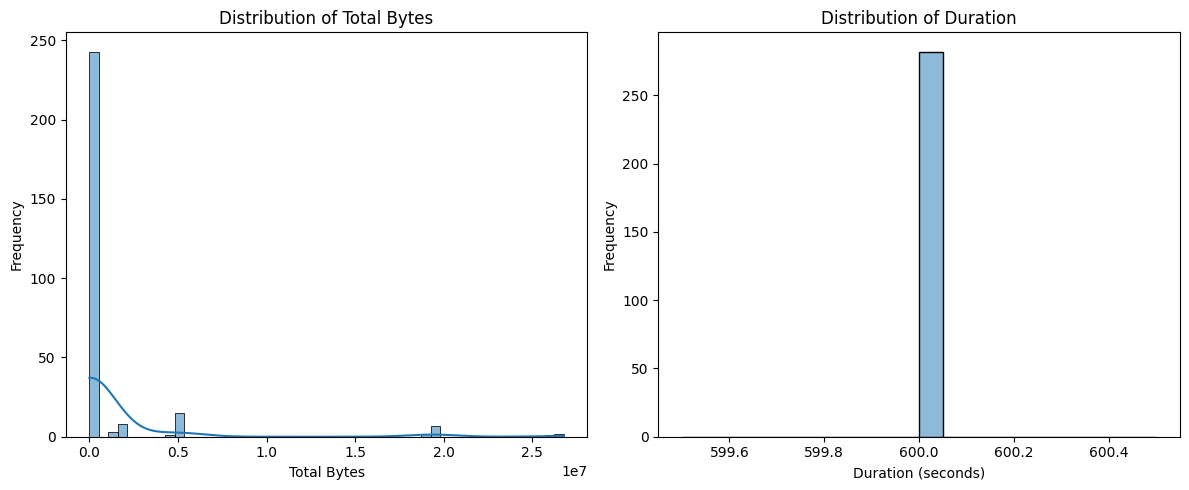

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_fe['total_bytes'], bins=50, kde=True)
plt.title('Distribution of Total Bytes')
plt.xlabel('Total Bytes')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_fe['duration'], bins=20, kde=True)
plt.title('Distribution of Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

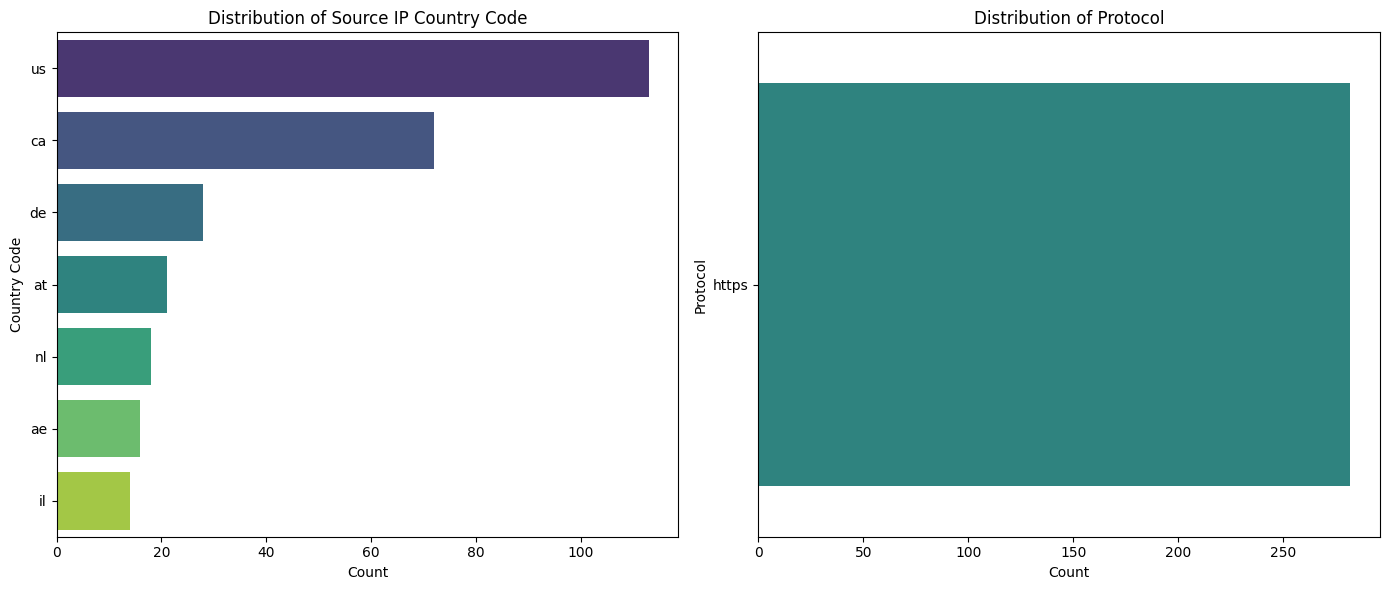

In [29]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df_fe, y='src_ip_country_code', order=df_fe['src_ip_country_code'].value_counts().index, palette='viridis')
plt.title('Distribution of Source IP Country Code')
plt.xlabel('Count')
plt.ylabel('Country Code')

plt.subplot(1, 2, 2)
sns.countplot(data=df_fe, y='protocol', order=df_fe['protocol'].value_counts().index, palette='viridis')
plt.title('Distribution of Protocol')
plt.xlabel('Count')
plt.ylabel('Protocol')

plt.tight_layout()
plt.show()

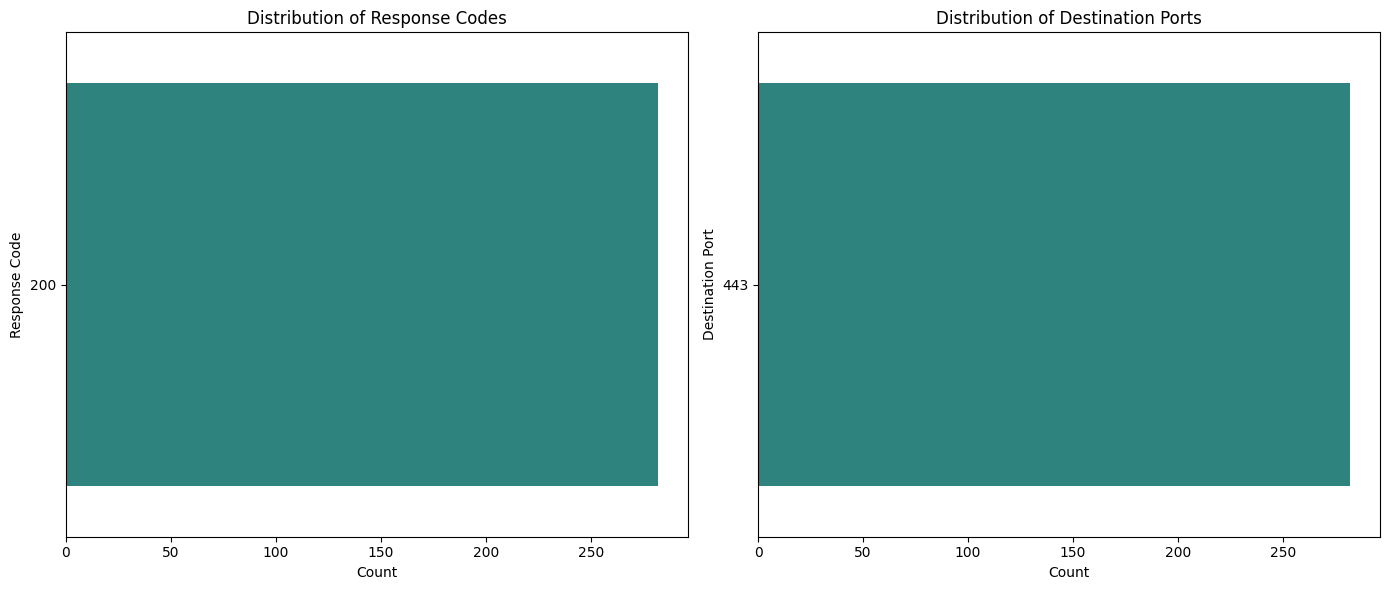

In [30]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df_fe, y='response.code', order=df_fe['response.code'].value_counts().index, palette='viridis')
plt.title('Distribution of Response Codes')
plt.xlabel('Count')
plt.ylabel('Response Code')

plt.subplot(1, 2, 2)
sns.countplot(data=df_fe, y='dst_port', order=df_fe['dst_port'].value_counts().index, palette='viridis')
plt.title('Distribution of Destination Ports')
plt.xlabel('Count')
plt.ylabel('Destination Port')

plt.tight_layout()
plt.show()

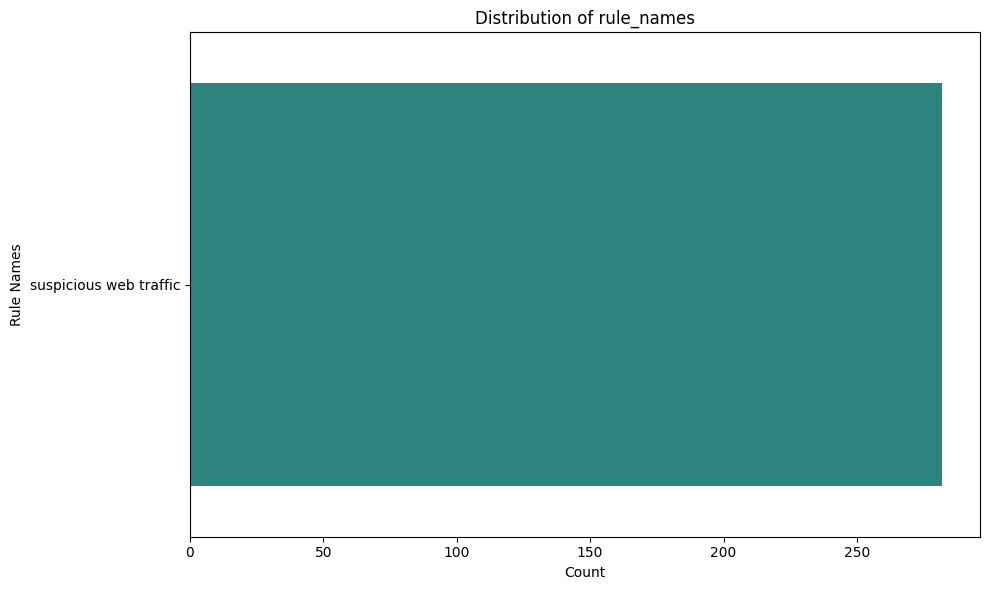

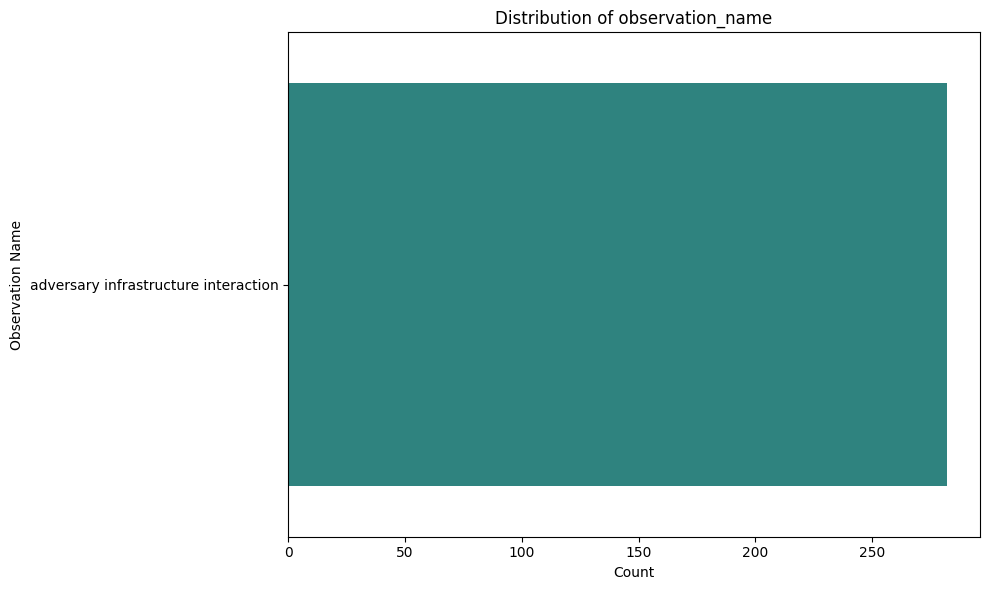

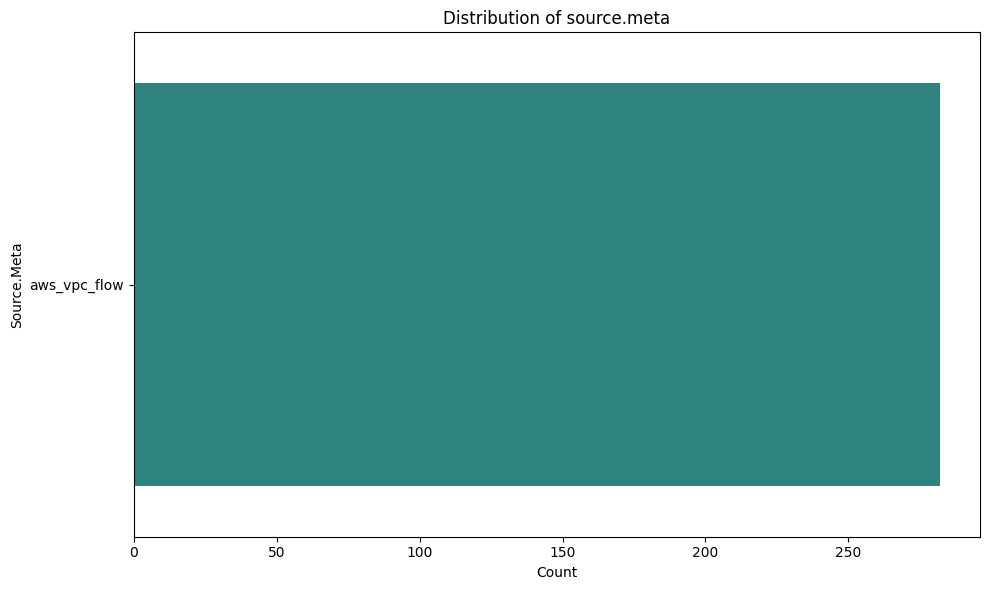

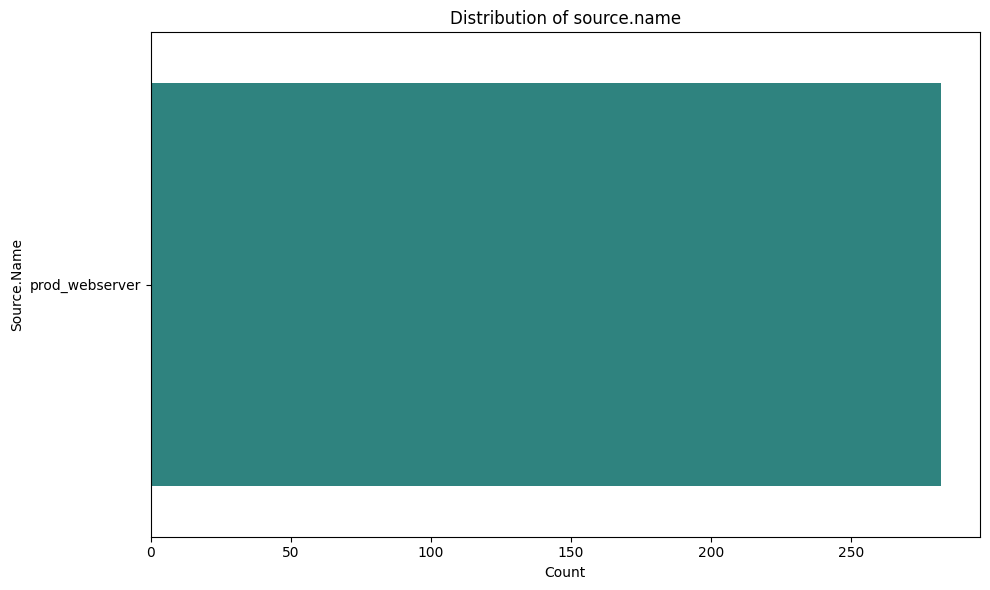

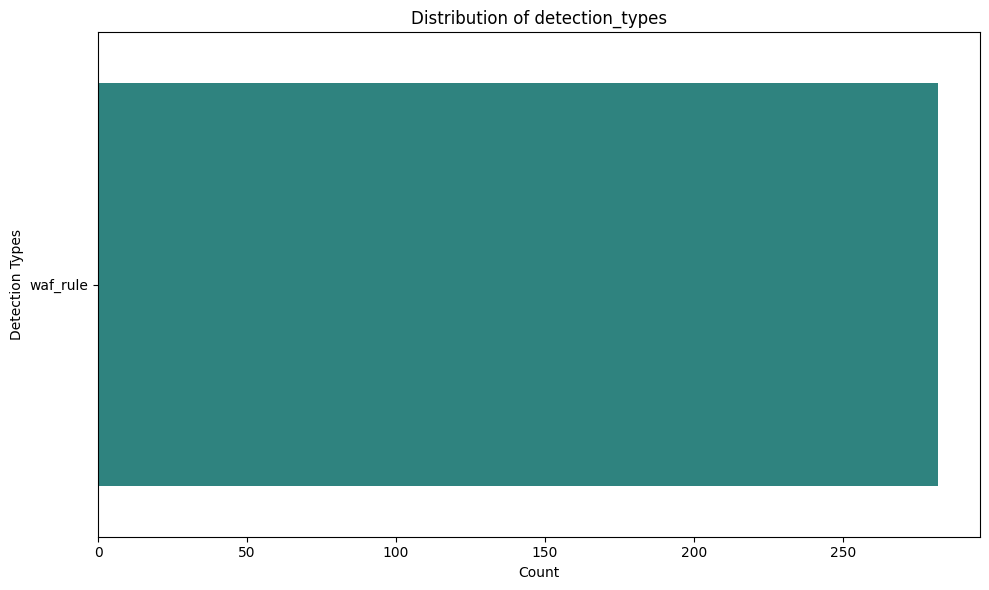

In [31]:
categorical_cols = ['rule_names', 'observation_name', 'source.meta', 'source.name', 'detection_types']

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_fe, y=col, order=df_fe[col].value_counts().index, palette='viridis')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Count')
    plt.ylabel(col.replace('_', ' ').title())
    plt.tight_layout()
    plt.show()

In [33]:
numerical_cols = ['bytes_in', 'bytes_out', 'duration', 'total_bytes']
categorical_cols = ['src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'detection_types']
features = df_fe[numerical_cols + categorical_cols]
display(features.head())

,bytes_in,bytes_out,duration,total_bytes,src_ip_country_code,protocol,response.code,dst_port,rule_names,observation_name,source.meta,source.name,detection_types
0,5602,12990,600.0,18592,ae,https,200,443,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,waf_rule
1,30912,18186,600.0,49098,us,https,200,443,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,waf_rule
2,28506,13468,600.0,41974,ca,https,200,443,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,waf_rule
3,30546,14278,600.0,44824,us,https,200,443,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,waf_rule
4,6526,13892,600.0,20418,nl,https,200,443,suspicious web traffic,adversary infrastructure interaction,aws_vpc_flow,prod_webserver,waf_rule


In [34]:
features_encoded = pd.get_dummies(features, columns=categorical_cols, drop_first=True)

display(features_encoded.head())

,bytes_in,bytes_out,duration,total_bytes,src_ip_country_code_at,src_ip_country_code_ca,src_ip_country_code_de,src_ip_country_code_il,src_ip_country_code_nl,src_ip_country_code_us
0,5602,12990,600.0,18592,False,False,False,False,False,False
1,30912,18186,600.0,49098,False,False,False,False,False,True
2,28506,13468,600.0,41974,False,True,False,False,False,False
3,30546,14278,600.0,44824,False,False,False,False,False,True
4,6526,13892,600.0,20418,False,False,False,False,True,False


In [35]:
scaler = StandardScaler()
features_encoded[numerical_cols] = scaler.fit_transform(features_encoded[numerical_cols])

display(features_encoded.head())

,bytes_in,bytes_out,duration,total_bytes,src_ip_country_code_at,src_ip_country_code_ca,src_ip_country_code_de,src_ip_country_code_il,src_ip_country_code_nl,src_ip_country_code_us
0,-0.288219,-0.281223,0.0,-0.287850,False,False,False,False,False,False
1,-0.282108,-0.260804,0.0,-0.280910,False,False,False,False,False,True
2,-0.282689,-0.279344,0.0,-0.282531,False,True,False,False,False,False
3,-0.282197,-0.276161,0.0,-0.281883,False,False,False,False,False,True
4,-0.287996,-0.277678,0.0,-0.287435,False,False,False,False,True,False


In [36]:
y = df_fe['detection_types']
X = features_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (225, 10)
Shape of X_test: (57, 10)
Shape of y_train: (225,)
Shape of y_test: (57,)


In [37]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

    waf_rule       1.00      1.00      1.00        57

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



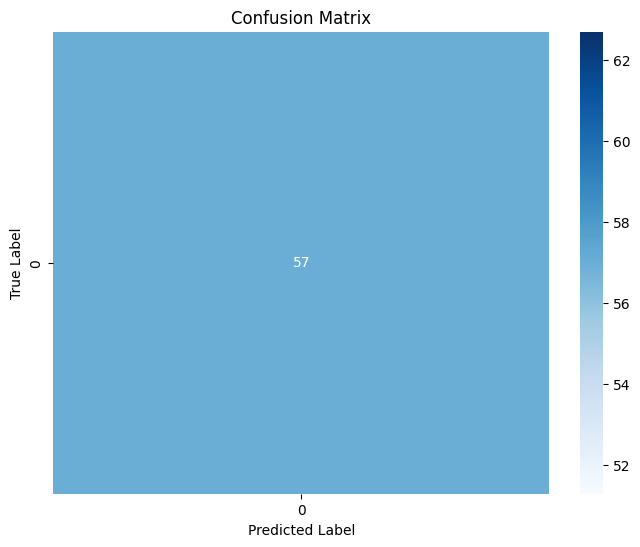

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

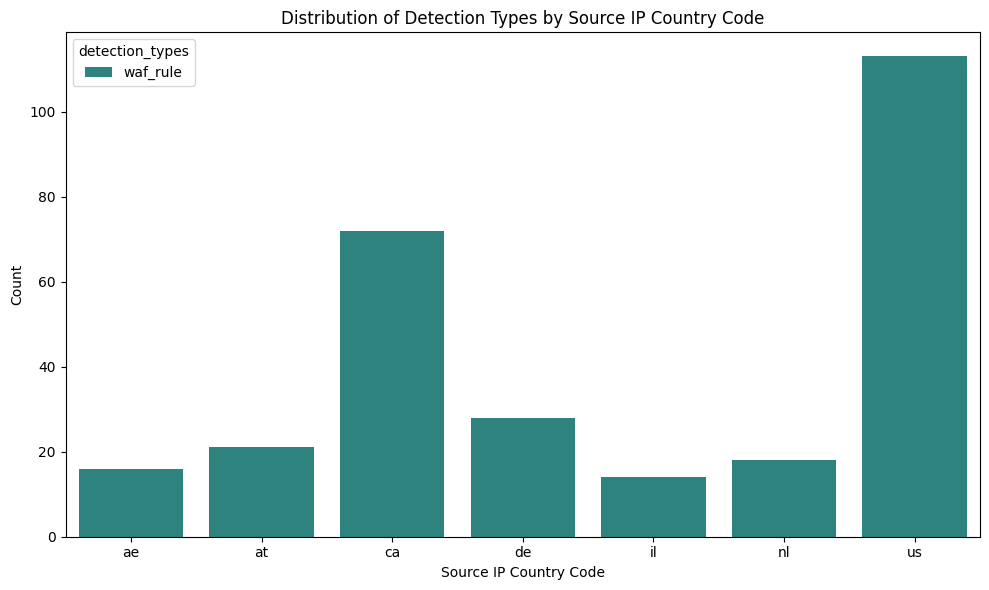

In [40]:
detection_by_country = df_fe.groupby(['src_ip_country_code', 'detection_types']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=detection_by_country, x='src_ip_country_code', y='count', hue='detection_types', palette='viridis')
plt.title('Distribution of Detection Types by Source IP Country Code')
plt.xlabel('Source IP Country Code')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

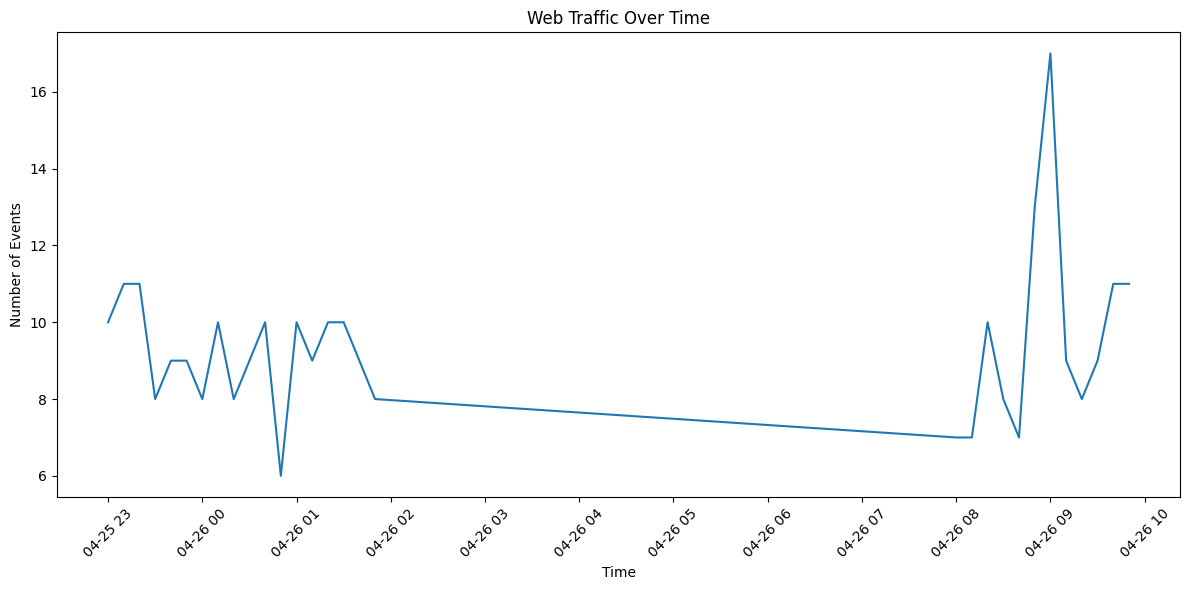

In [41]:
web_traffic_over_time = df_fe['time'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.plot(web_traffic_over_time.index, web_traffic_over_time.values)
plt.title('Web Traffic Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()